<a href="https://colab.research.google.com/github/ajaythakur3369/LGMVIP-DataScience-Task-Number/blob/main/Task_10_ML_Facial_Recognition_to_detect_mood_and_suggest_songs_accordingly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name - ML Facial Recognition to detect mood and suggest songs accordingly**
## **Developed By - Ajay Thakur (2016kuec2026@iiitkota.ac.in)**
## **Branch Name - Electronics and Communication Engineering**
## **Institute Name - Indian Institute of Information Technology Kota (An Institute of National Importance under an Act of Parliament)**
## **Guided By - Mr. Aman Kesarwani (Founder of LetsGrowMore Private Limited)**
## **Submitted To - LetsGrowMore Pvt. Ltd.**
## **Project Link (GitHub) - [Click here](https://github.com/ajaythakur3369/LGMVIP-DataScience-Task-Number)**
## **Project Link (Drive) - [Click here](https://colab.research.google.com/drive/1bx5X9GTcuA0yvSQ4NyEmpPoXupCcEjNR)**

## **Importing the Libraries**

In [ ]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import os
import cv2
import tensorflow as tf
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from sklearn.metrics import classification_report, confusion_matrix
main_accent_colour = "#b366ff"
dim_colour="darkgrey"
main_palette = ["#FBE5C0", "#DD9A30", "#F88379", "#FF6FC2", "purple", "#D086F6", "#B0D2C2", "#4C5D70", "#6FA2CE", "#382D24", "#3ACF3A", "#7D7D00"]

In [ ]:
# Access the Drive from Colab, for accessing the file
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train_dir = '/content/drive/MyDrive/Folders/train/'

In [ ]:
test_dir = '/content/drive/MyDrive/Folders/test/'

In [ ]:
row = 48
col = 48

In [ ]:
classes = len(os.listdir('/content/drive/MyDrive/Folders/train'))

In [ ]:
import os
print(os.listdir('/content/drive/MyDrive/Folders/archive1'))

['test', 'train']


In [ ]:
print('Train Directory :')
print(os.listdir('/content/drive/MyDrive/Folders/train'))

Train Directory :
['neutral', 'disgust', 'surprise', 'angry', 'sad', 'fear', 'happy']


In [ ]:
print("Test_Directory :")
print(os.listdir('/content/drive/MyDrive/Folders/test'))

Test_Directory :
['surprise', 'sad', 'fear', 'disgust', 'angry', 'happy', 'neutral']


In [ ]:
def Classes_Count( path, name):
    Classes_Dict = {}
    for Class in os.listdir(path):
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
    df = pd.DataFrame(Classes_Dict, index=[name])
    return df
Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [ ]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<Axes: >

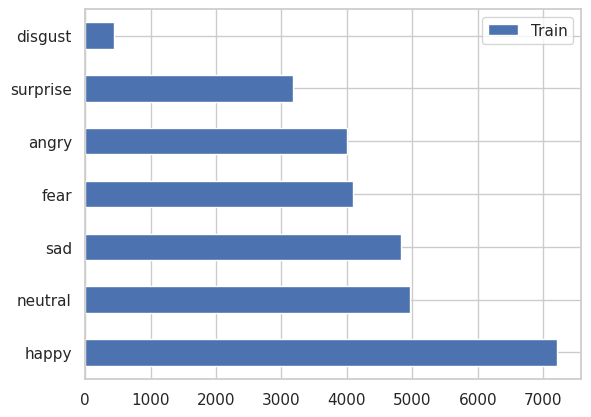

In [ ]:
Train_Count.plot(kind='barh')

<Axes: >

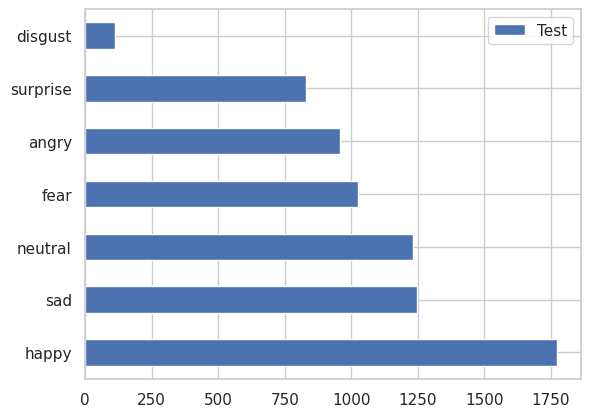

In [ ]:
Test_Count.plot(kind='barh')

In [ ]:
print("Train Set :")

train_count = []
for folder in os.listdir(train_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(train_dir+folder)), "image")
    train_count.append(len(os.listdir(train_dir+folder)))

print()

test_count = []
print("Test Set :")
for folder in os.listdir(test_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(test_dir+folder)), "images")
    test_count.append(len(os.listdir(test_dir+folder)))

Train Set :
neutral folder contains		 4965 image
disgust folder contains		 436 image
surprise folder contains		 3171 image
angry folder contains		 3995 image
sad folder contains		 4830 image
fear folder contains		 4097 image
happy folder contains		 7215 image

Test Set :
surprise folder contains		 831 images
sad folder contains		 1247 images
fear folder contains		 1024 images
disgust folder contains		 111 images
angry folder contains		 958 images
happy folder contains		 1774 images
neutral folder contains		 1233 images


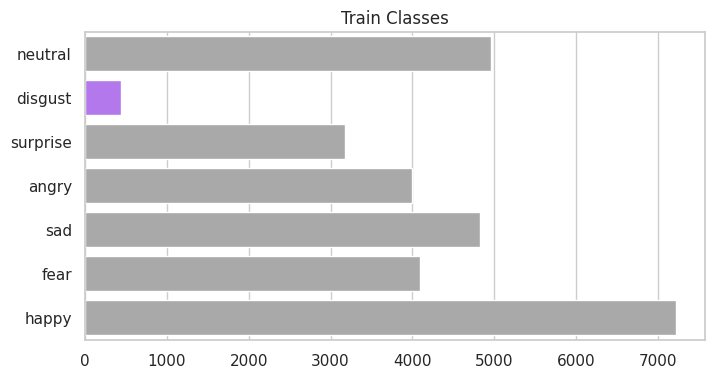

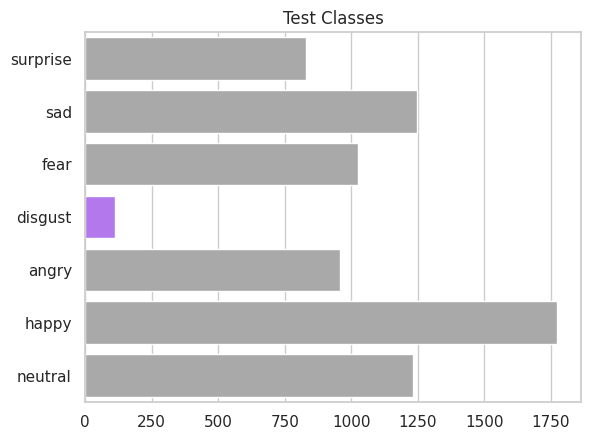

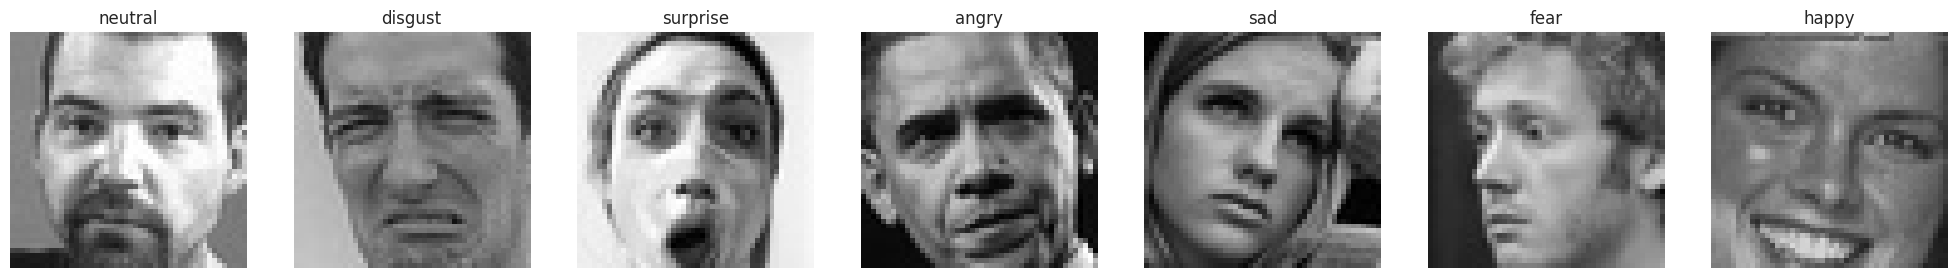

In [ ]:
vals = ["disgust"]
palette = {c: dim_colour if c not in vals else main_accent_colour for c in os.listdir(train_dir)}

plt.figure(figsize=(8,4))

ax = sns.barplot(y=os.listdir(train_dir),
                 x=train_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Train Classes')

plt.show()

print()

ax = sns.barplot(y=os.listdir(test_dir),
                 x=test_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Test Classes')

plt.show()

print()

plt.figure(figsize=(25,25))

i = 1
for folder in os.listdir(train_dir):

    img = load_img((train_dir + folder +'/'+ os.listdir(train_dir + folder)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(folder)
    plt.axis('off')
    i += 1

plt.show()

In [ ]:
def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
def get_model(input_size, classes=7):

    model = tf.keras.models.Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(classes, activation='softmax'))

    model.compile(optimizer=Adam(lr=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
fernet = get_model((row, col, 1), classes)
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
fernet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
chk_path = '/content/drive/MyDrive/Folders/ferNet.h5'
log_dir = "/content/drive/MyDrive/Folders/train" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # checkpoint/logs/

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]
callbacks

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                  validation_data=test_set,
                  epochs=10,
                  callbacks=callbacks,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)

Epoch 1/10
448/448 [==============================] - ETA: 0s - loss: 1.6751 - accuracy: 0.3588
Epoch 1: val_loss improved from 1.62917 to 1.57980, saving model to /content/drive/MyDrive/Folders/ferNet.h5
448/448 [==============================] - 1590s 4s/step - loss: 1.6751 - accuracy: 0.3588 - val_loss: 1.5798 - val_accuracy: 0.4061 - lr: 0.0010
Epoch 2/10
448/448 [==============================] - ETA: 0s - loss: 1.6255 - accuracy: 0.3853
Epoch 2: val_loss improved from 1.57980 to 1.50122, saving model to /content/drive/MyDrive/Folders/ferNet.h5
448/448 [==============================] - 1538s 3s/step - loss: 1.6255 - accuracy: 0.3853 - val_loss: 1.5012 - val_accuracy: 0.4364 - lr: 0.0010
Epoch 3/10
448/448 [==============================] - ETA: 0s - loss: 1.5770 - accuracy: 0.4079
Epoch 3: val_loss improved from 1.50122 to 1.46643, saving model to /content/drive/MyDrive/Folders/ferNet.h5
448/448 [==============================] - 1526s 3s/step - loss: 1.5770 - accuracy: 0.4079 - 

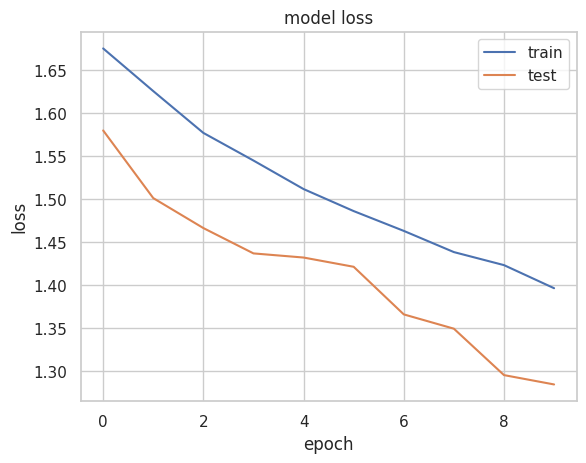

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

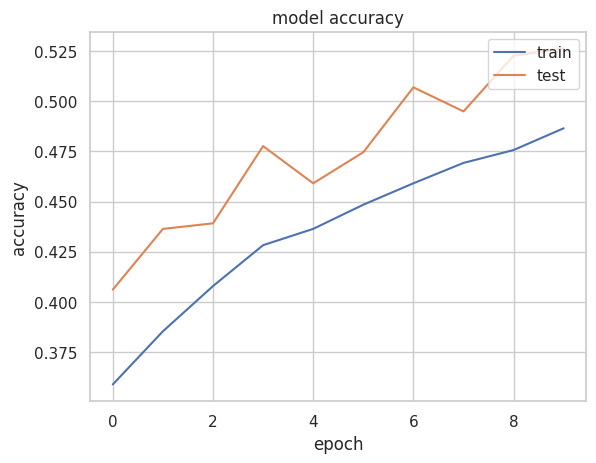

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [ ]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 101s 893ms/step - loss: 1.2840 - accuracy: 0.5266
final train accuracy = 52.42 , validation accuracy = 52.66


449/449 [==============================] - 432s 962ms/step
Confusion Matrix
[[ 469    5  337 1434  711  677  362]
 [  43    0   52  179   63   63   36]
 [ 506    4  393 1473  685  652  384]
 [ 914    7  684 2706 1147 1115  642]
 [ 548    4  444 1899  805  799  466]
 [ 587    2  481 1747  796  774  443]
 [ 392    0  297 1138  507  540  297]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.12      0.13      3995
     disgust       0.00      0.00      0.00       436
        fear       0.15      0.10      0.12      4097
       happy       0.26      0.38      0.30      7215
     neutral       0.17      0.16      0.17      4965
         sad       0.17      0.16      0.16      4830
    surprise       0.11      0.09      0.10      3171

    accuracy                           0.19     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.19      0.18     28709



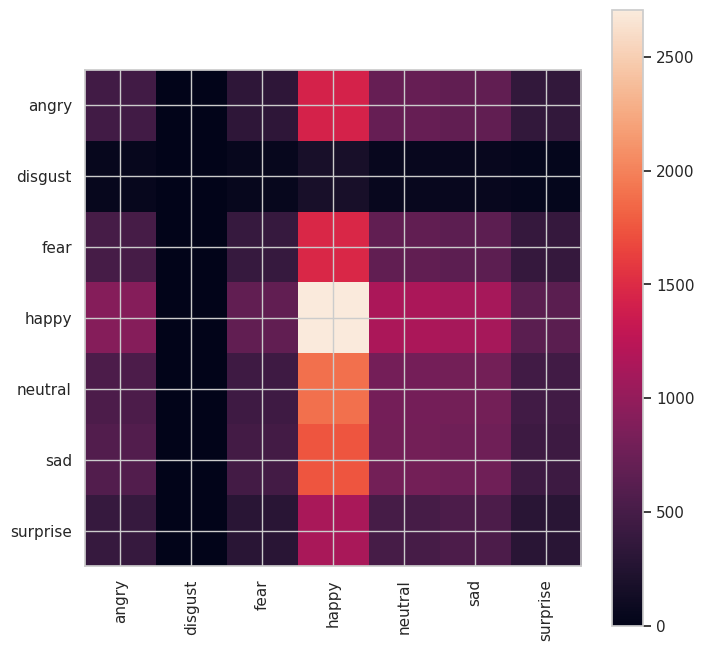

In [ ]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

113/113 [==============================] - 98s 866ms/step
Confusion Matrix
[[140   1  92 341 165 127  92]
 [ 21   0   6  41  19  15   9]
 [134   0  99 338 201 157  95]
 [293   0 156 586 303 259 177]
 [185   0 116 414 220 173 125]
 [189   1 111 439 193 196 118]
 [137   1  68 265 158 120  82]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.15      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.10      0.12      1024
       happy       0.24      0.33      0.28      1774
     neutral       0.17      0.18      0.18      1233
         sad       0.19      0.16      0.17      1247
    surprise       0.12      0.10      0.11       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.18      7178



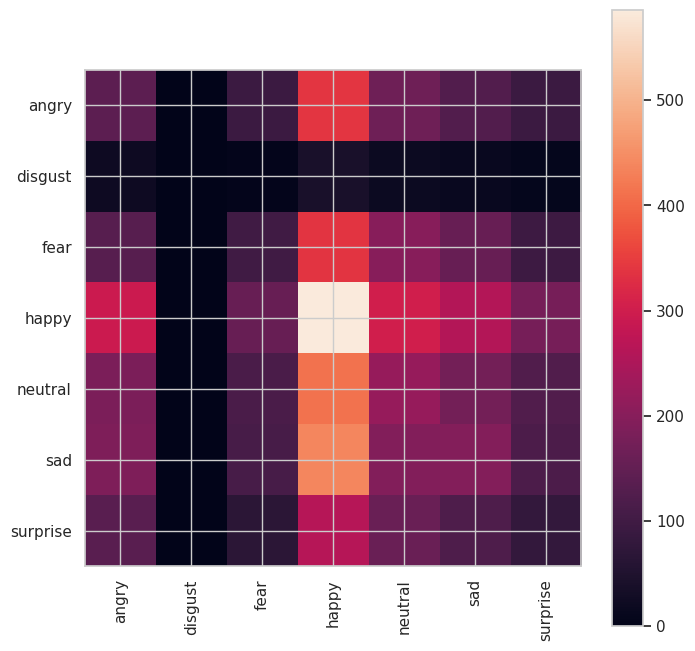

In [ ]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

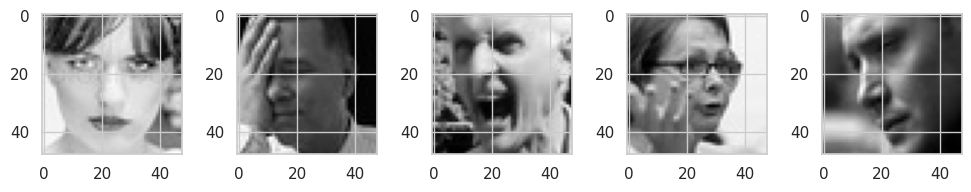

In [ ]:
plot_images(test_dir+"/"+"angry")

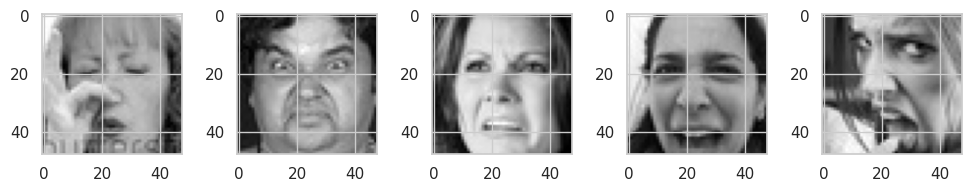

In [ ]:
plot_images(test_dir+"/"+"disgust")

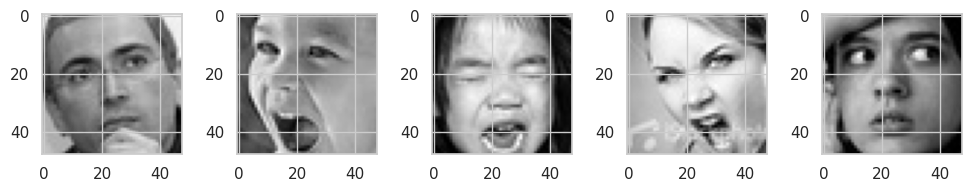

In [ ]:
plot_images(test_dir+"/"+"fear")

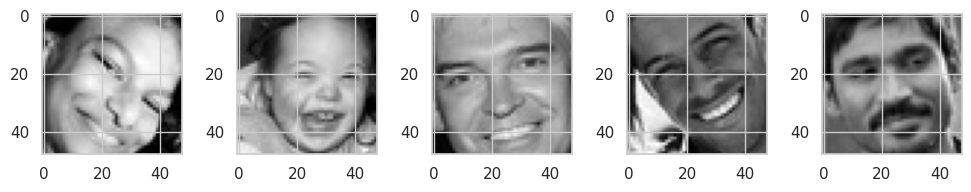

In [ ]:
plot_images(test_dir+"/"+"happy")

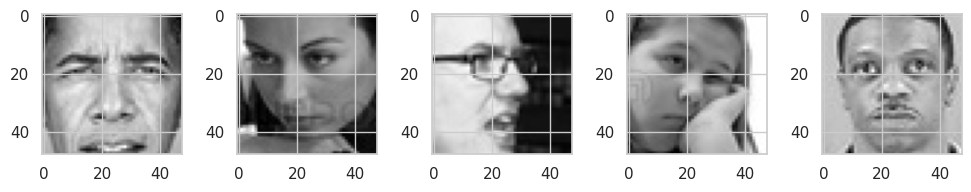

In [ ]:
plot_images(test_dir+"/"+"neutral")

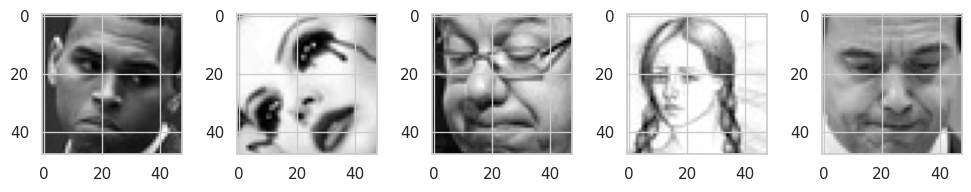

In [ ]:
plot_images(test_dir+"/"+"sad")

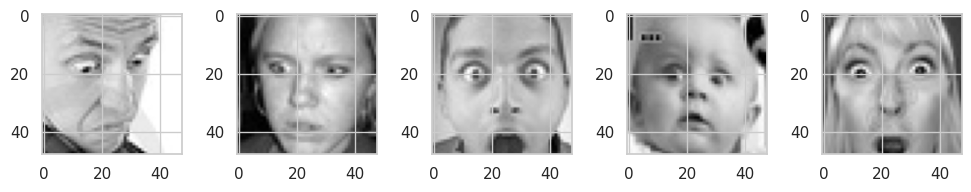

In [ ]:
plot_images(test_dir+"/"+"surprise")

In [ ]:
mood_music = pd.read_csv("/content/drive/MyDrive/Folders/data_moods.csv")
mood_music.head()

,name,album,artist,id,release_date,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,mood
0,1999,1999,Prince,2H7PHVdQ3mXqEHXcvclTB0,1982-10-27,68,379266,0.866,0.13700,0.730,0.000000,0.0843,0.625,-8.201,0.0767,118.523,5,4,Happy
1,23,23,Blonde Redhead,4HIwL9ii9CcXpTOTzMq0MP,2007-04-16,43,318800,0.381,0.01890,0.832,0.196000,0.1530,0.166,-5.069,0.0492,120.255,8,4,Sad
2,9 Crimes,9,Damien Rice,5GZEeowhvSieFDiR8fQ2im,2006-11-06,60,217946,0.346,0.91300,0.139,0.000077,0.0934,0.116,-15.326,0.0321,136.168,0,4,Sad
3,99 Luftballons,99 Luftballons,Nena,6HA97v4wEGQ5TUClRM0XLc,1984-08-21,2,233000,0.466,0.08900,0.438,0.000006,0.1130,0.587,-12.858,0.0608,193.100,4,4,Happy
4,A Boy Brushed Red Living In Black And White,They're Only Chasing Safety,Underoath,47IWLfIKOKhFnz1FUEUIkE,2004-01-01,60,268000,0.419,0.00171,0.932,0.000000,0.1370,0.445,-3.604,0.1060,169.881,1,4,Energetic


In [ ]:
mood_music = pd.read_csv("/content/drive/MyDrive/Folders/data_moods.csv")
mood_music = mood_music[['name','artist','mood']]
mood_music.head()

,name,artist,mood
0,1999,Prince,Happy
1,23,Blonde Redhead,Sad
2,9 Crimes,Damien Rice,Sad
3,99 Luftballons,Nena,Happy
4,A Boy Brushed Red Living In Black And White,Underoath,Energetic


(48, 48)


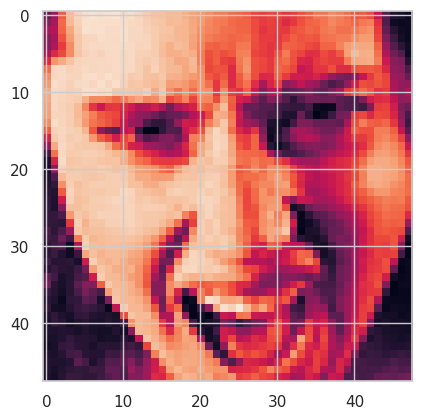

In [ ]:
from keras.utils import load_img
img = load_img("/content/drive/MyDrive/Folders/test/angry/PrivateTest_2775163.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)

In [ ]:
training_set.class_indices
label_dict = ['angry', 'disgust', 'fear','happy', 'neutral', 'sad', 'surprise']

In [ ]:
from keras.utils import img_to_array
test_image = img_to_array(img)
test_image = np.expand_dims(test_image, axis = 0)
result = fernet.predict(test_image)
result[0]

1/1 [==============================] - 0s 203ms/step


array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
res = np.argmax(result[0])
res

0

In [ ]:
print('predicted Label for that image is: {}'.format(label_dict[res]))

predicted Label for that image is: angry


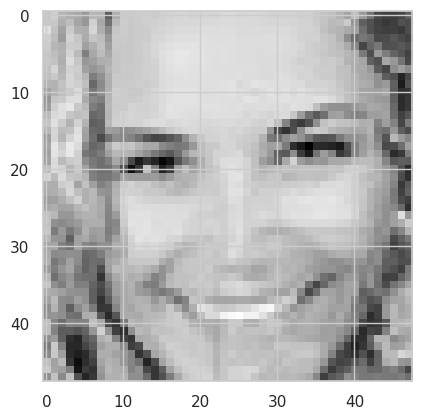

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Folders/test/happy/PrivateTest_10077120.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap='gray')
plt.show()

In [ ]:
image = cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=fernet.predict(img)
result=np.argmax(predict_x,axis=1)
result[0]

1/1 [==============================] - 0s 60ms/step


2

In [ ]:
if(result[0]==0 or result[0]==1 or result[0]==2 ):
    #for angery,disgust,fear
    filter1=mood_music['mood']=='Calm'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==3 or result[0]==4):
    #for happy, neutral
    filter1=mood_music['mood']=='Happy'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==5):
       #for Sad
    filter1=mood_music['mood']=='Sad'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==6):
     #for surprise
    filter1=mood_music['mood']=='Energetic'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)

,index,name,artist,mood
0,418,Pierre,Hicham Chahidi,Calm
1,169,Essential Attitudes,Peals,Calm
2,196,Focus,Light of Sun,Calm
3,371,Night,Wilson Trouvé,Calm
4,121,Curious Morning,Michael Orvind,Calm


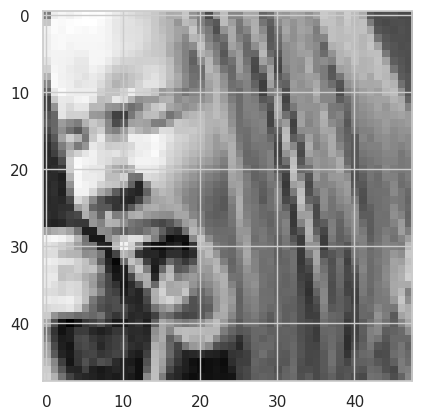

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Folders/test/angry/PrivateTest_39884579.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap='gray')
plt.show()

In [ ]:
image = cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=fernet.predict(img)
result=np.argmax(predict_x,axis=1)
result[0]

1/1 [==============================] - 0s 61ms/step


6

In [ ]:
if(result[0]==0 or result[0]==1 or result[0]==2 ):

    #for angry,disgust,fear
    filter1=mood_music['mood']=='Calm'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==3 or result[0]==4):

    #for happy, neutral
    filter1=mood_music['mood']=='Happy'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==5):

    #for Sad
    filter1=mood_music['mood']=='Sad'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==6):

    #for surprise
    filter1=mood_music['mood']=='Energetic'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)

,index,name,artist,mood
0,427,Prayer Of The Refugee,Rise Against,Energetic
1,23,All in the Suit That You Wear,Stone Temple Pilots,Energetic
2,537,Tears Don't Fall,Bullet For My Valentine,Energetic
3,462,Same Direction,Hoobastank,Energetic
4,432,Pressure,Seth Hills,Energetic
